In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.utils.random import sample_without_replacement
from UBIC import fit_blr, UBIC, decreasing_values_indices
# from skscope_tools import best_subset_all_solutions, abess_all_solutions

from tqdm import tqdm

from pysr import PySRRegressor

fontsize = 20 # for plots

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

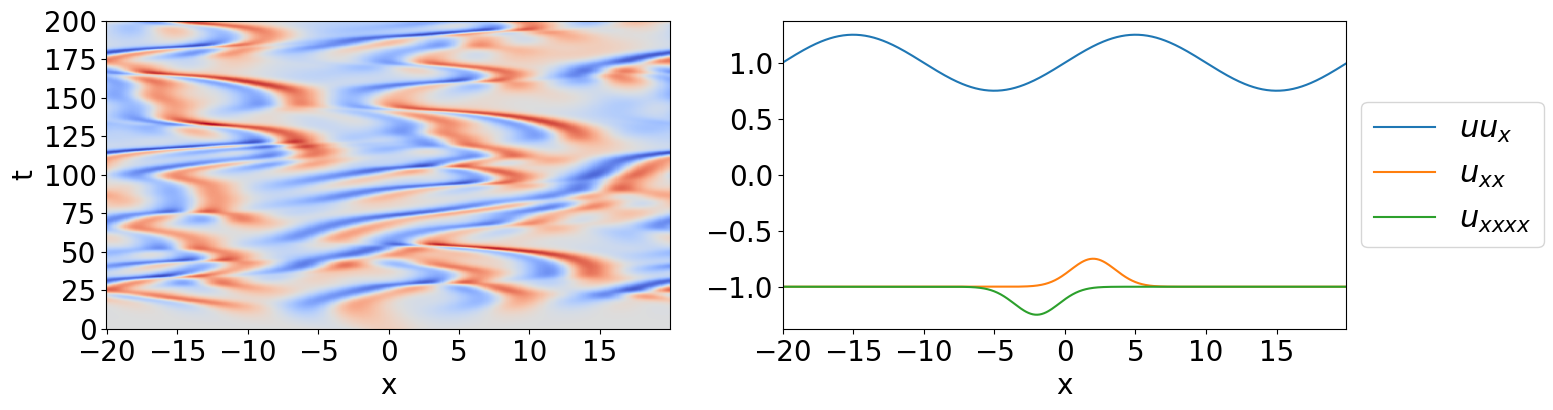

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
# u = u_full[:,-m:]
# t = t[-m:]
u = u_full[:,:m]
t = t[:m]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=False)

In [7]:
# # Build linear systems
# wx = 10
# wt = 10
# deg_x = 6
# deg_t = 4

# Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
#                                        deg_x = deg_x, deg_t = deg_t, 
#                                        width_x = wx, width_t = wt)
# n2 = n - 2*wx
# m2 = m - 2*wt

# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

4 u_xx
5 u_xxx
6 u_xxxx
7 uu_x


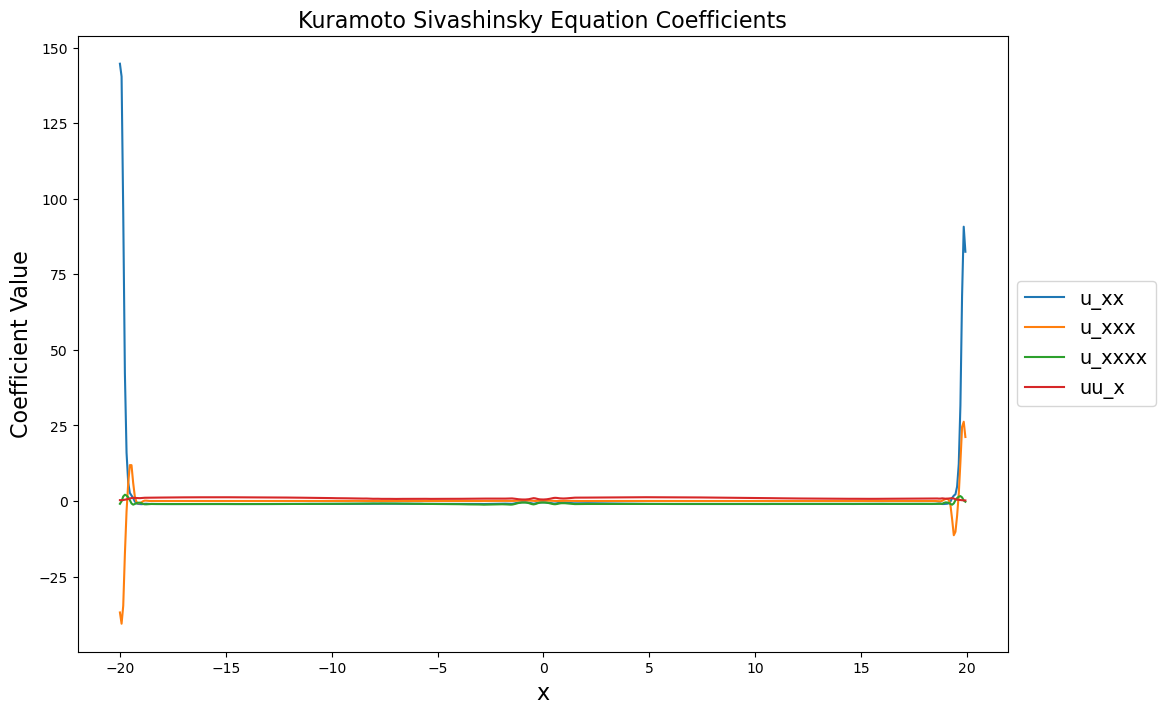

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()
# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
candidates = {(0, 1, 3, 4, 6, 7, 8, 9, 11),
              (0, 1, 3, 4, 6, 7, 10, 11),
              (1, 2, 3, 4, 6, 7, 8, 12, 15, 16),
              (3, 4, 6, 7),
              (3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 18),
              (3, 4, 6, 7, 9, 12),
              (3, 4, 6, 7, 9, 12, 18),
              (3, 4, 6, 7, 13),
              (4, 6, 7),
              (6, 7),
              (7,)}
candidates = sorted(candidates, key=len)
rhs_des[4], rhs_des[6], rhs_des[7]

('u_xx', 'u_xxxx', 'uu_x')

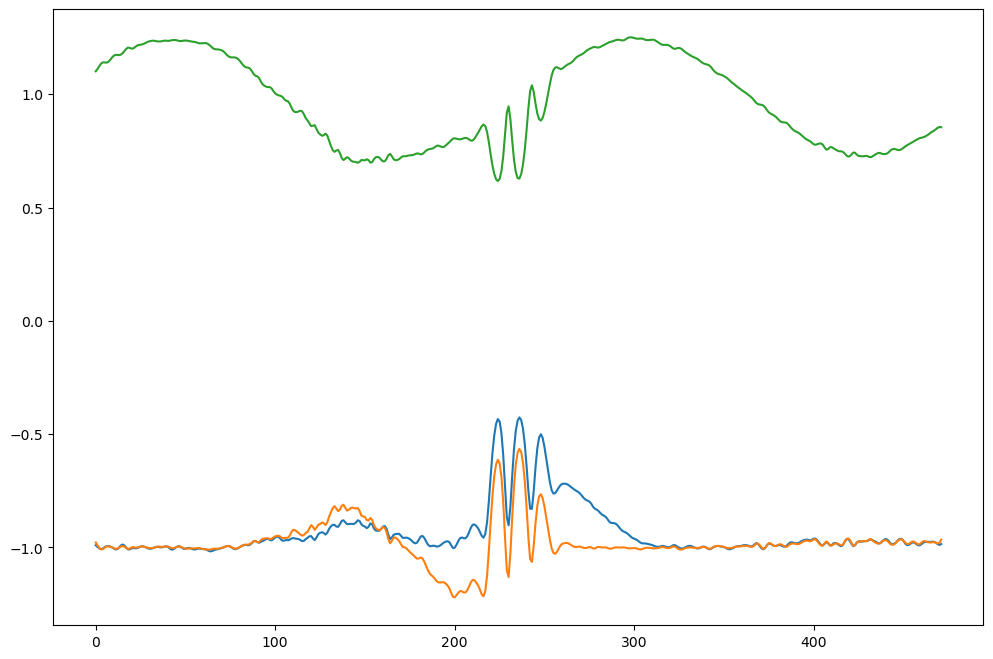

In [11]:
f_u_xx, f_u_xxxx, f_uu_x = linear_fit_grouped_data((Theta_grouped, Ut_grouped), 
                                             considered_indices=candidates[2])
plt.plot(f_u_xx[20:-20])
plt.plot(f_u_xxxx[20:-20])
plt.plot(f_uu_x[20:-20])
plt.show()

In [15]:
# y1 = (sin(x₀ * -0.32253) * -0.25117) - -0.95951
# y1 = (-0.25113 * sin(x₀ * -0.32253)) + 0.95955
model1 = PySRRegressor(
    parsimony=0.01, 
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=["sin", "cos"], 
    denoise=False, 
)

win = 16; w = 15
A = x[win-1:-w].reshape(-1,1)
B = pd.Series(f_uu_x).rolling(window=win).mean().iloc[win-1:].values[:-w].reshape(-1,1)
# plt.plot(A, B); plt.show()
model1.fit(A, B)

[ Info: Started!



Expressions evaluated per second: 2.410e+05
Head worker occupation: 25.4%
Progress: 523 / 1500 total iterations (34.867%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.203e+02  1.594e+01  y = x₀
2           4.114e-02  7.980e+00  y = sin(1.2858)
5           3.856e-02  2.161e-02  y = (-0.0046748 * x₀) + 0.95945
7           3.855e-02  1.292e-04  y = cos(0.46683 * cos(x₀ * -0.13547))
8           8.554e-03  1.506e+00  y = (-0.25113 * sin(x₀ * -0.32253)) + 0.95955
10          5.243e-03  2.448e-01  y = 0.95567 + (sin((-0.31924 * x₀) + 0.3234) * -0.26367)
11          5.057e-03  3.597e-02  y = 0.95564 + (-0.30133 * sin(sin(-0.32079 * (x₀ - 1.0576))))
12          4.981e-03  1.518e-02  y = 0.95564 + (-0.3294 * sin(sin(sin((x₀ - 1.0475) * -0.32233)...
                                  )))
13          3.876e-03  2.508e-01  y = 1.1009 + (-0.35261 * sin(sin(-0.31629 * (x₀ - 1.1

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.6259378   
	1         1.310062                                      sin(1.285759)   
	2         0.021606                      (-0.004674755 * x0) + 0.95945   
	3         0.005851              cos(cos(0.082310416 * x0) - 0.628859)   
	4         1.494141  (-0.25112787 * sin(x0 * -0.32252666)) + 0.9595501   
	5         0.244810  (-0.26367608 * sin(0.3230395 + (-0.31943187 * ...   
	6         0.035988  0.95551765 + (-0.3009507 * sin(sin(0.34207076 ...   
	7         0.230418  cos(sin(sin((x0 - 1.3197032) * -0.31546062) + ...   
	8         0.040123  (-0.36455923 * sin(sin(-0.3162855 * (x0 - 1.10...   
	9         0.040027  (-0.4847125 * sin(sin(sin((x0 - 1.1216884) * -...   
	10  >>>>  0.227548  cos(sin(-2.2354562 + sin((-0.31546062 * (x0 - ...   
	11        0.036314  cos(sin(-2.2354562 + sin((-0.31546062 * (x0 - ...   
	12        0.023154  cos(sin(-2.2354562 + sin(((x0 - (cos(x0) * 0.6...   
	13        0.034066  cos(sin(-2.2354562 + sin(((x0 - sin(cos(x0 + 0...   
	14        0.013530  0.19746058 + cos(sin(sin(sin(((x0 - 1.3197032)...   
	15        0.014857  0.19746058 + cos(sin(sin(sin(((x0 - 1.3197032)...   
	
	        loss  complexity  
	0   0.152496           1  
	1   0.041144           2  
	2   0.038562           5  
	3   0.038113           7  
	4   0.008554           8  
	5   0.005242          10  
	6   0.005057          11  
	7   0.004016          12  
	8   0.003858          13  
	9   0.003707          14  
	10  0.002953          15  
	11  0.002847          16  
	12  0.002782          17  
	13  0.002689          18  
	14  0.002653          19  
	15  0.002614          20  
]

In [20]:
# y2 = -0.97764 + (0.2091 * exp(((x₀ - 3.3079) * x₀) * -0.1777))
# y2 = exp(-2.4803 - ((x₀ + -2.5827) * x₀)) + -0.95397
model2 = PySRRegressor(
    parsimony=0.01, 
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=["exp"], 
    denoise=True, 
)

# win = 16; w = 15
win = 31; w = 15
A = x[win-1:][w:-w].reshape(-1,1)
B = pd.Series(f_u_xx).rolling(window=win).mean().iloc[win-1:].values[w:-w].reshape(-1,1)
# plt.plot(A, B)
model2.fit(A, B)

[ Info: Started!



Expressions evaluated per second: 2.500e+05
Head worker occupation: 28.2%
Progress: 552 / 1500 total iterations (36.800%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.196e-02  1.594e+01  y = -0.70417
3           1.019e-02  9.025e-01  y = -0.83082 - 0.10088
5           1.019e-02  1.915e-04  y = -0.93192 + (0.00019302 * x₀)
6           1.008e-02  1.075e-02  y = -0.92929 - (6.3018e-10 * exp(x₀))
7           7.217e-03  3.340e-01  y = -0.87179 + ((-0.00056947 * x₀) * x₀)
9           5.023e-03  1.812e-01  y = -0.95766 + exp(x₀ - exp(x₀ * 0.59029))
10          4.215e-03  1.754e-01  y = -0.9917 + exp(-1.4843 - ((0.036295 * x₀) * x₀))
11          1.261e-03  1.206e+00  y = exp((x₀ - exp(0.41618 * x₀)) + -0.69231) + -0.98495
13          7.320e-04  2.721e-01  y = exp(-1.5054 - ((x₀ - exp(1.2807)) * (x₀ * 0.1463))) + -0.9...
                                  7847
16         

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                        -0.93170226   
	1         4.905956e-08                       -0.93191737 - -0.00019579167   
	2         1.915652e-04                 -0.93192226 + (0.00019301732 * x0)   
	3         1.075217e-02            -0.92911786 + (-6.314627e-10 * exp(x0))   
	4         3.339545e-01         -0.87179476 + ((-0.00056947314 * x0) * x0)   
	5         2.628016e-01        -0.97846603 + exp(x0 - exp(0.5006851 * x0))   
	6         4.173800e-02  exp(-2.4802957 - ((x0 + -2.5827367) * x0)) + -...   
	7   >>>>  1.534353e+00  exp((x0 * -0.46719766) - exp(0.33867103 - x0))...   
	8         1.766437e-01  -0.97731245 + exp(-1.5054326 - (x0 * ((x0 * 0....   
	9         1.014220e-02  exp(-1.5054326 - ((x0 - exp(1.2806816)) * (x0 ...   
	10        3.456179e-03  exp(-1.086447 - (((0.14626744 * x0) + -0.34918...   
	11        1.830159e-05  exp(-1.086447 - (((0.14626744 * x0) + -0.34918...   
	12        1.615202e-01  exp(-1.086447 - ((-0.1699559 + (0.079651356 * ...   
	13        6.468012e-03  exp(-1.086447 - ((((0.079651356 * x0) * 1.0823...   
	
	        loss  complexity  
	0   0.010192           1  
	1   0.010192           3  
	2   0.010188           5  
	3   0.010079           6  
	4   0.007217           7  
	5   0.004267           9  
	6   0.004092          10  
	7   0.000882          11  
	8   0.000739          12  
	9   0.000732          13  
	10  0.000729          14  
	11  0.000729          16  
	12  0.000621          17  
	13  0.000613          19  
]

In [34]:
# y3 = (0.19909 * (exp((x₀ * x₀) * -0.26832) * x₀)) + -0.9798
# y3 = y = exp(-1.7509 - (x₀ * x₀)) + -0.98854
model3 = PySRRegressor(
    parsimony=0.01, 
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=["exp"], 
    denoise=True, 
)

# win = 31; w = 15
win = 16; w = 15
A = x[win-1:][w:-w].reshape(-1,1)
B = pd.Series(f_u_xxxx).rolling(window=win).mean().iloc[win-1:].values[w:-w].reshape(-1,1)
# plt.plot(A, B)
model3.fit(A, B)

[ Info: Started!



Expressions evaluated per second: 3.000e+05
Head worker occupation: 26.0%
Progress: 648 / 1500 total iterations (43.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.442e-01  1.594e+01  y = -1.7795
3           5.263e-03  2.404e+00  y = -0.56497 - 0.41513
5           5.258e-03  4.888e-04  y = -0.97998 - (0.00021532 * x₀)
6           5.258e-03  2.444e-06  y = exp(0.00021532 * x₀) * -0.97998
7           5.250e-03  1.532e-03  y = (-2.7794e-05 * (x₀ * x₀)) + -0.97764
8           4.299e-03  1.999e-01  y = exp(-1.7509 - (x₀ * x₀)) + -0.98854
9           3.290e-03  2.674e-01  y = (x₀ * exp(x₀ - exp(x₀))) + -0.96428
11          2.239e-03  1.925e-01  y = -0.97566 + (exp(x₀ - exp(x₀)) * (x₀ - -0.41518))
13          1.940e-03  7.171e-02  y = -0.97562 + (exp(x₀ - exp(x₀ + 0.19875)) * (x₀ - -0.57859))
14          1.929e-03  5.615e-03  y = (exp(x₀ - exp(x₀ - -0.50658)) * (exp

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -1.7794672   
	1         2.403655                           -0.56497353 - 0.41512933   
	2         0.000489                  -0.9799833 - (0.00021532249 * x0)   
	3         0.000003               exp(0.00021532249 * x0) * -0.9799833   
	4         0.001822           ((x0 * -3.837991e-5) * x0) + -0.97583634   
	5         0.199591             exp(-1.750855 - (x0 * x0)) + -0.988536   
	6         0.267421                (x0 * exp(x0 - exp(x0))) + -0.96428   
	7         0.061253           -1.9666251 + exp(exp(x0 - exp(x0)) * x0)   
	8   >>>>  0.323677  -0.9756581 + (exp(x0 - exp(x0)) * (x0 - -0.415...   
	9         0.110763  -0.9766816 * exp((-0.51394874 - x0) * exp(x0 -...   
	10        0.034795  (exp(x0 - exp(x0 + 0.2080543)) * (x0 + 0.55054...   
	11        0.023925  exp(exp(x0 - exp(x0 + 0.13947162)) * (-0.56696...   
	12        0.000598  -0.9799833 * exp(exp(x0 - exp(x0 + 0.13947162)...   
	13        0.012098  -0.9756581 + ((x0 - -0.62540776) * exp(x0 - ex...   
	14        0.026294  (exp((x0 * 0.6758107) - exp(x0)) * (x0 - ((-0....   
	
	        loss  complexity  
	0   0.644250           1  
	1   0.005263           3  
	2   0.005258           5  
	3   0.005258           6  
	4   0.005249           7  
	5   0.004299           8  
	6   0.003290           9  
	7   0.003095          10  
	8   0.002239          11  
	9   0.002004          12  
	10  0.001936          13  
	11  0.001890          14  
	12  0.001888          16  
	13  0.001865          17  
	14  0.001769          19  
]